# Estimates of power consumption and solar compensation

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [129]:
df = pd.read_csv('archive/Combine_hourly_est.csv', low_memory=False)
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

print(df)

                         AEP    COMED  DAYTON    DEOK      DOM     DUQ  \
Datetime                                                                 
1998-12-31 01:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-12-31 02:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-12-31 03:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-12-31 04:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
1998-12-31 05:00:00      NaN      NaN     NaN     NaN      NaN     NaN   
...                      ...      ...     ...     ...      ...     ...   
2018-01-01 20:00:00  21089.0  13858.0  2732.0  4426.0  18418.0  1962.0   
2018-01-01 21:00:00  20999.0  13758.0  2724.0  4419.0  18567.0  1940.0   
2018-01-01 22:00:00  20820.0  13627.0  2664.0  4355.0  18307.0  1891.0   
2018-01-01 23:00:00  20415.0  13336.0  2614.0  4224.0  17814.0  1820.0   
2018-01-02 00:00:00  19993.0  12816.0  2552.0  4100.0  17428.0  1721.0   

                       EKPC      FE  

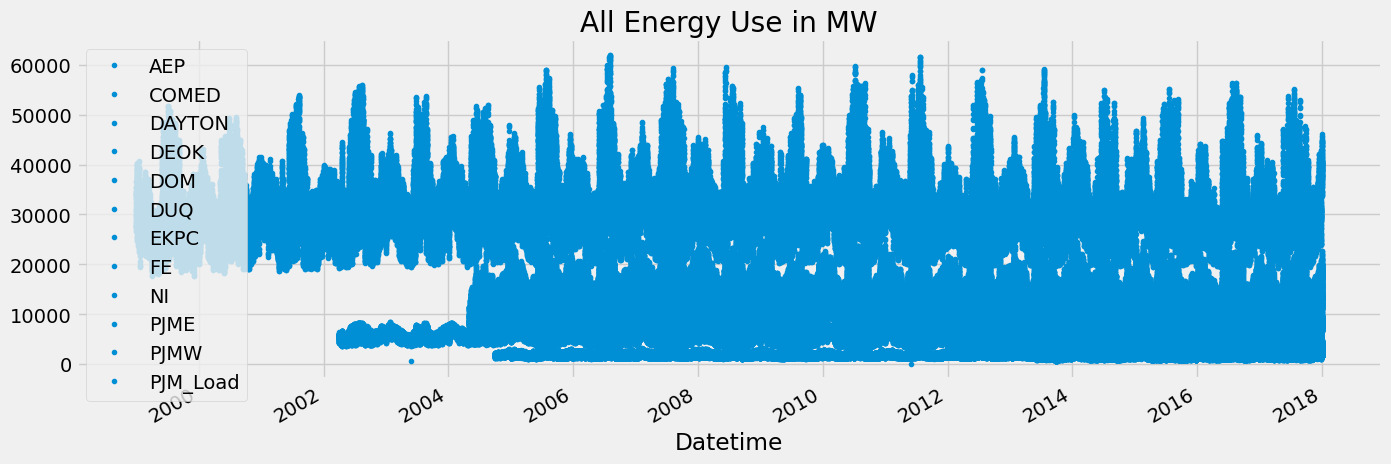

In [130]:
df = df.loc['1998-12-31':'2018-01-02'] #display from 1998-2018 datetime

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='All Energy Use in MW')
plt.show()

In [131]:
df = df.loc[~np.isinf(df['PJMW']), :]
df = df.dropna(subset=['PJMW']) #drop NaN
# Check for NaN and infinity values
print(df['PJMW'].isnull().sum())  # Check for NaN values
print(np.isinf(df['PJMW']).sum()) # Check for infinity values
print(df['PJMW'].max())           # Check the maximum value

0
0
9594.0


# Train / Test Split

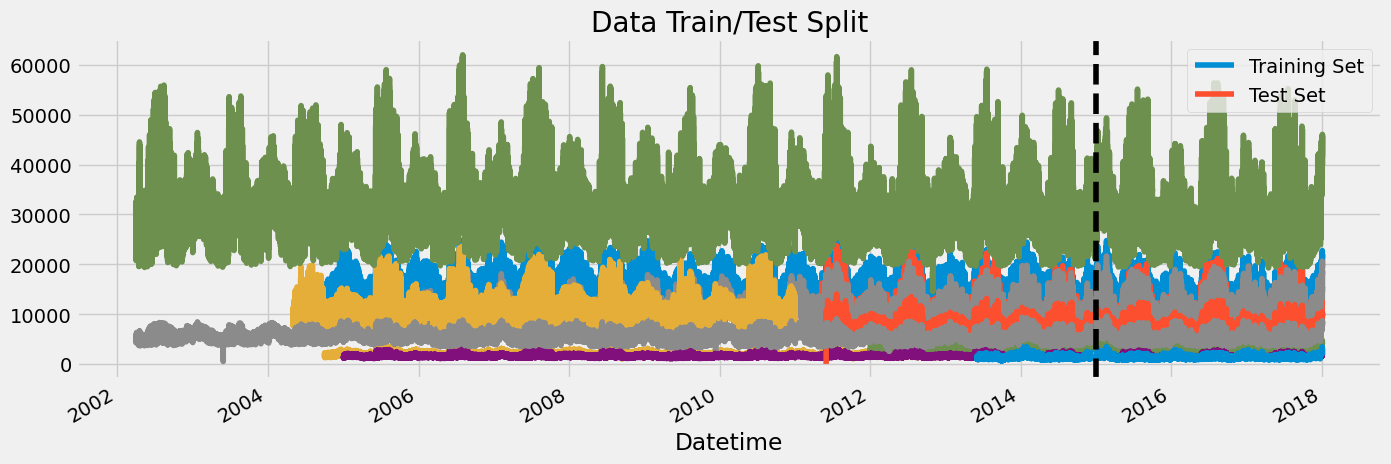

In [132]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

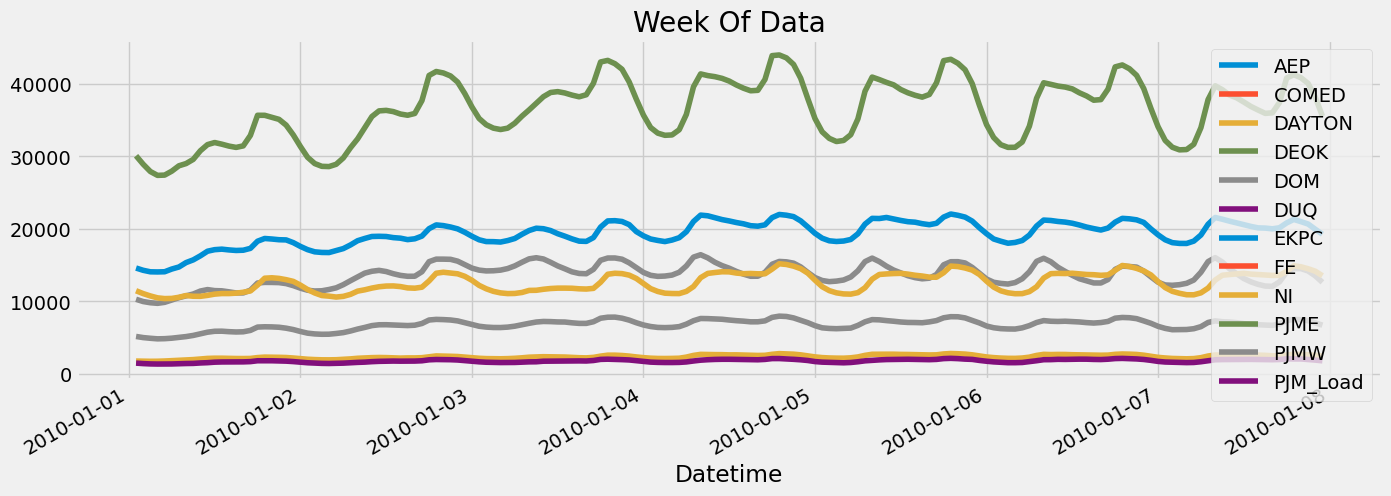

In [133]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

# Feature Creation

In [134]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

# Visualize our Feature / Target Relationship

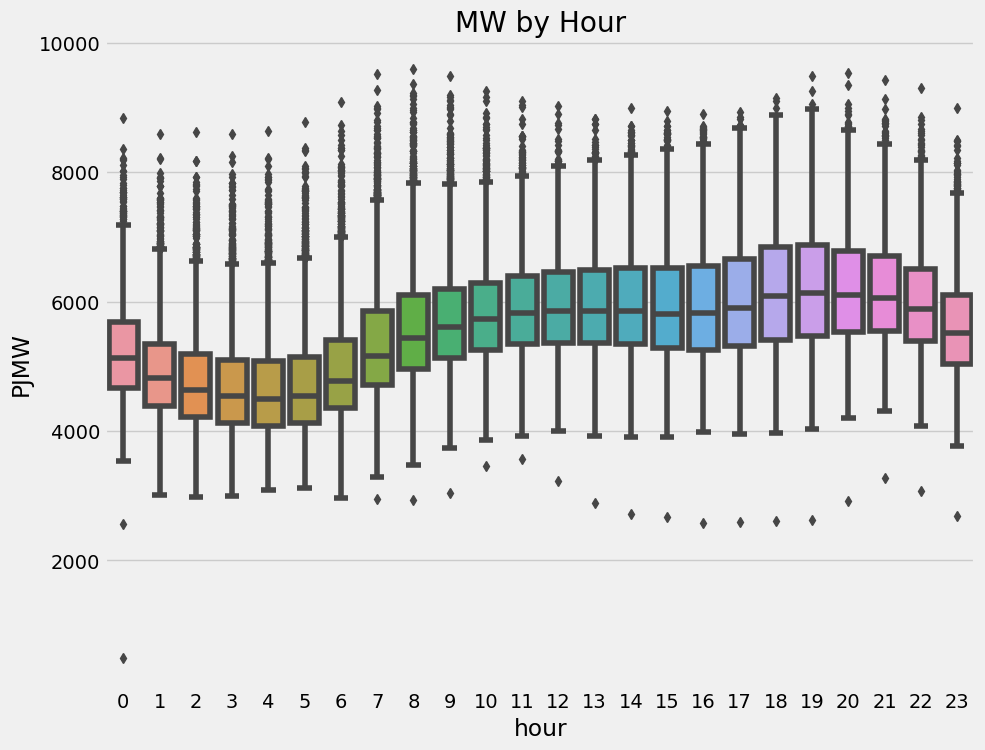

In [135]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJMW')
ax.set_title('MW by Hour')
plt.show()

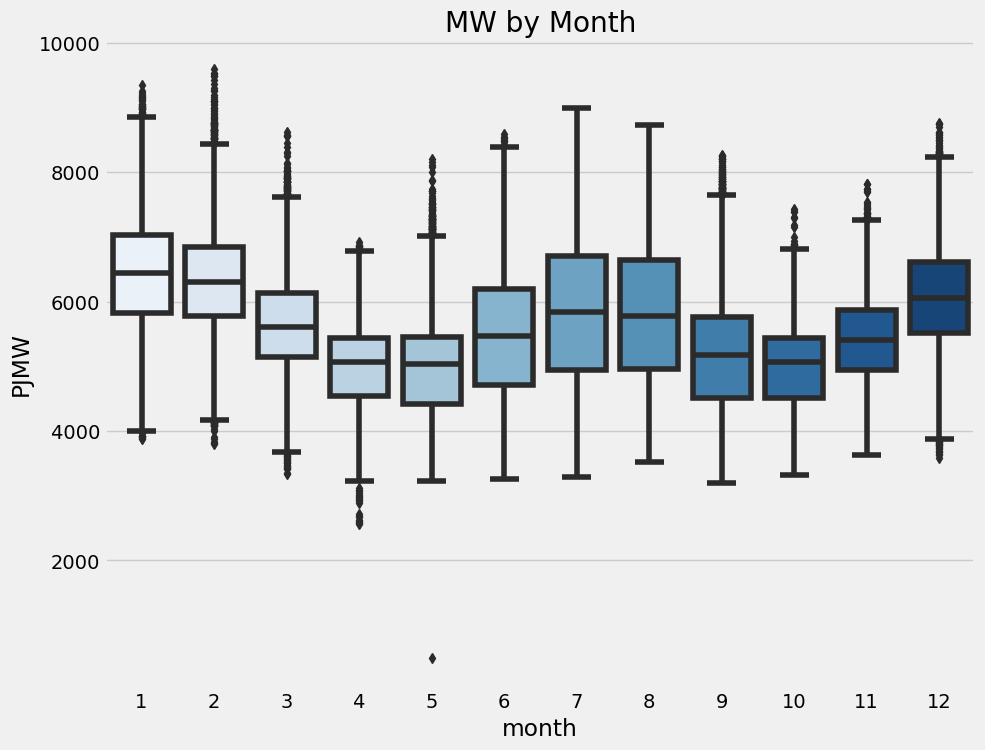

In [136]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJMW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create our Model

In [137]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJMW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [162]:
import warnings

# Suppress XGBoost warning
warnings.filterwarnings('ignore', message=".*reg:linear.*", category=UserWarning)

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:5625.61344	validation_1-rmse:5608.43032
[100]	validation_0-rmse:2153.59860	validation_1-rmse:2154.94956
[200]	validation_0-rmse:973.62599	validation_1-rmse:1021.75709
[300]	validation_0-rmse:640.09790	validation_1-rmse:734.29885
[400]	validation_0-rmse:553.62288	validation_1-rmse:668.42403
[500]	validation_0-rmse:525.89564	validation_1-rmse:653.02081
[600]	validation_0-rmse:511.06594	validation_1-rmse:647.50548
[700]	validation_0-rmse:500.50703	validation_1-rmse:645.14121
[800]	validation_0-rmse:493.23141	validation_1-rmse:644.04910
[900]	validation_0-rmse:487.17355	validation_1-rmse:643.02676
[999]	validation_0-rmse:480.93372	validation_1-rmse:642.82211


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance

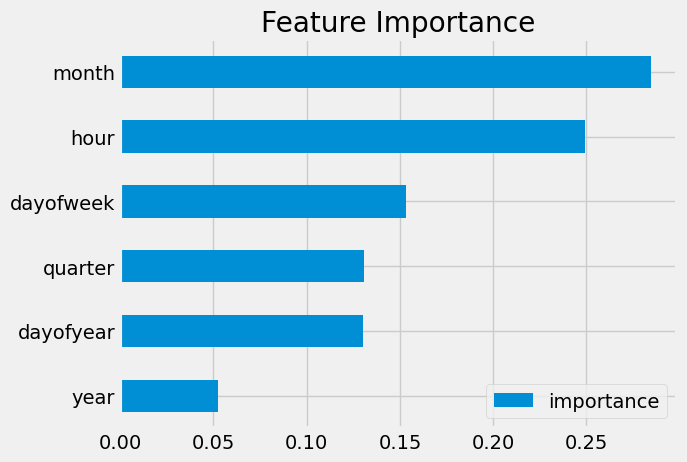

In [139]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

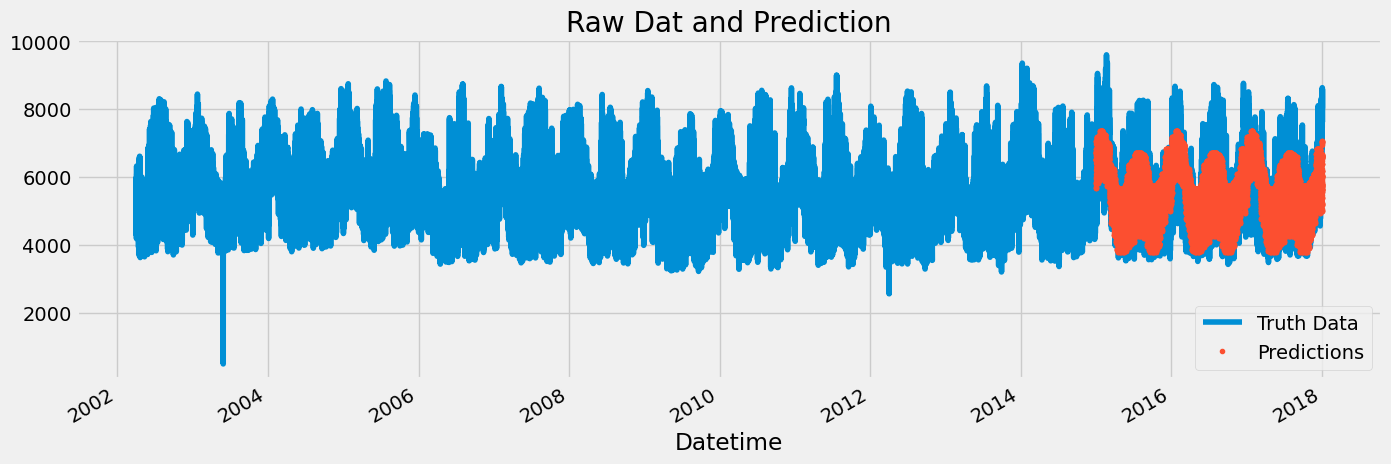

In [147]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJMW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

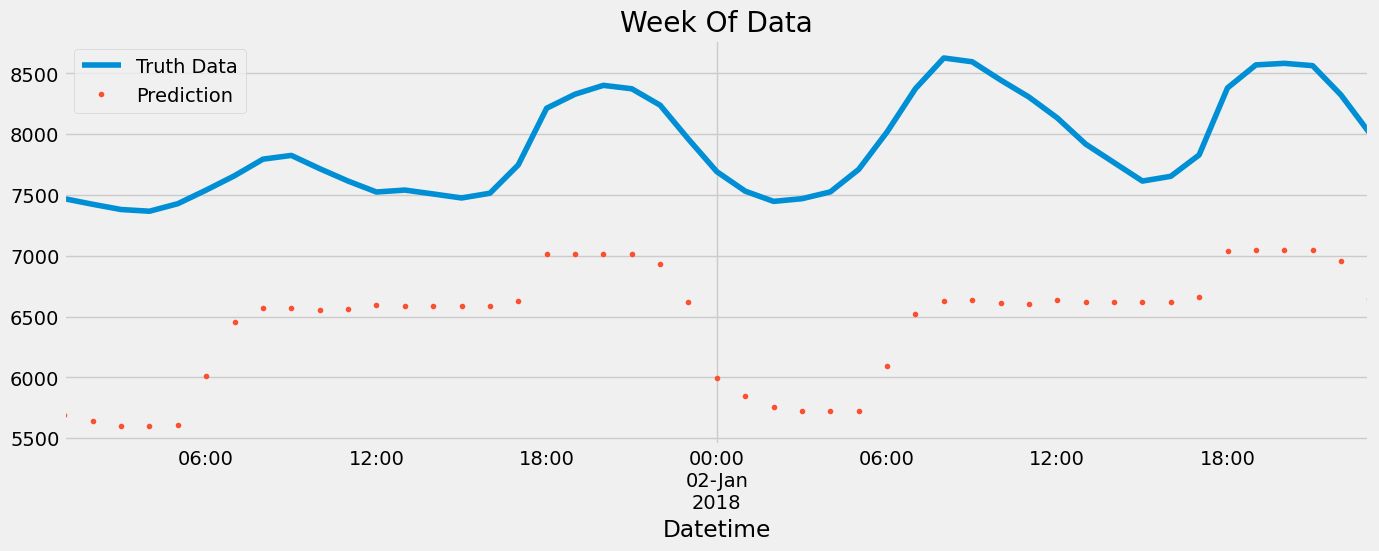

In [159]:
ax = df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['PJMW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [160]:
score = np.sqrt(mean_squared_error(test['PJMW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 642.13


# Calculate Error
- Look at the worst and best predicted days

In [161]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2015-02-20    2086.594381
2017-12-31    1978.529358
2015-02-15    1976.841919
2015-02-16    1948.153890
2015-02-19    1907.533305
2017-02-24    1778.944784
2017-12-28    1762.660278
2017-02-23    1723.048014
2017-02-08    1706.050252
2016-12-16    1662.290141
Name: error, dtype: float64

# Compare different power consumption and solar compensation from global datasets

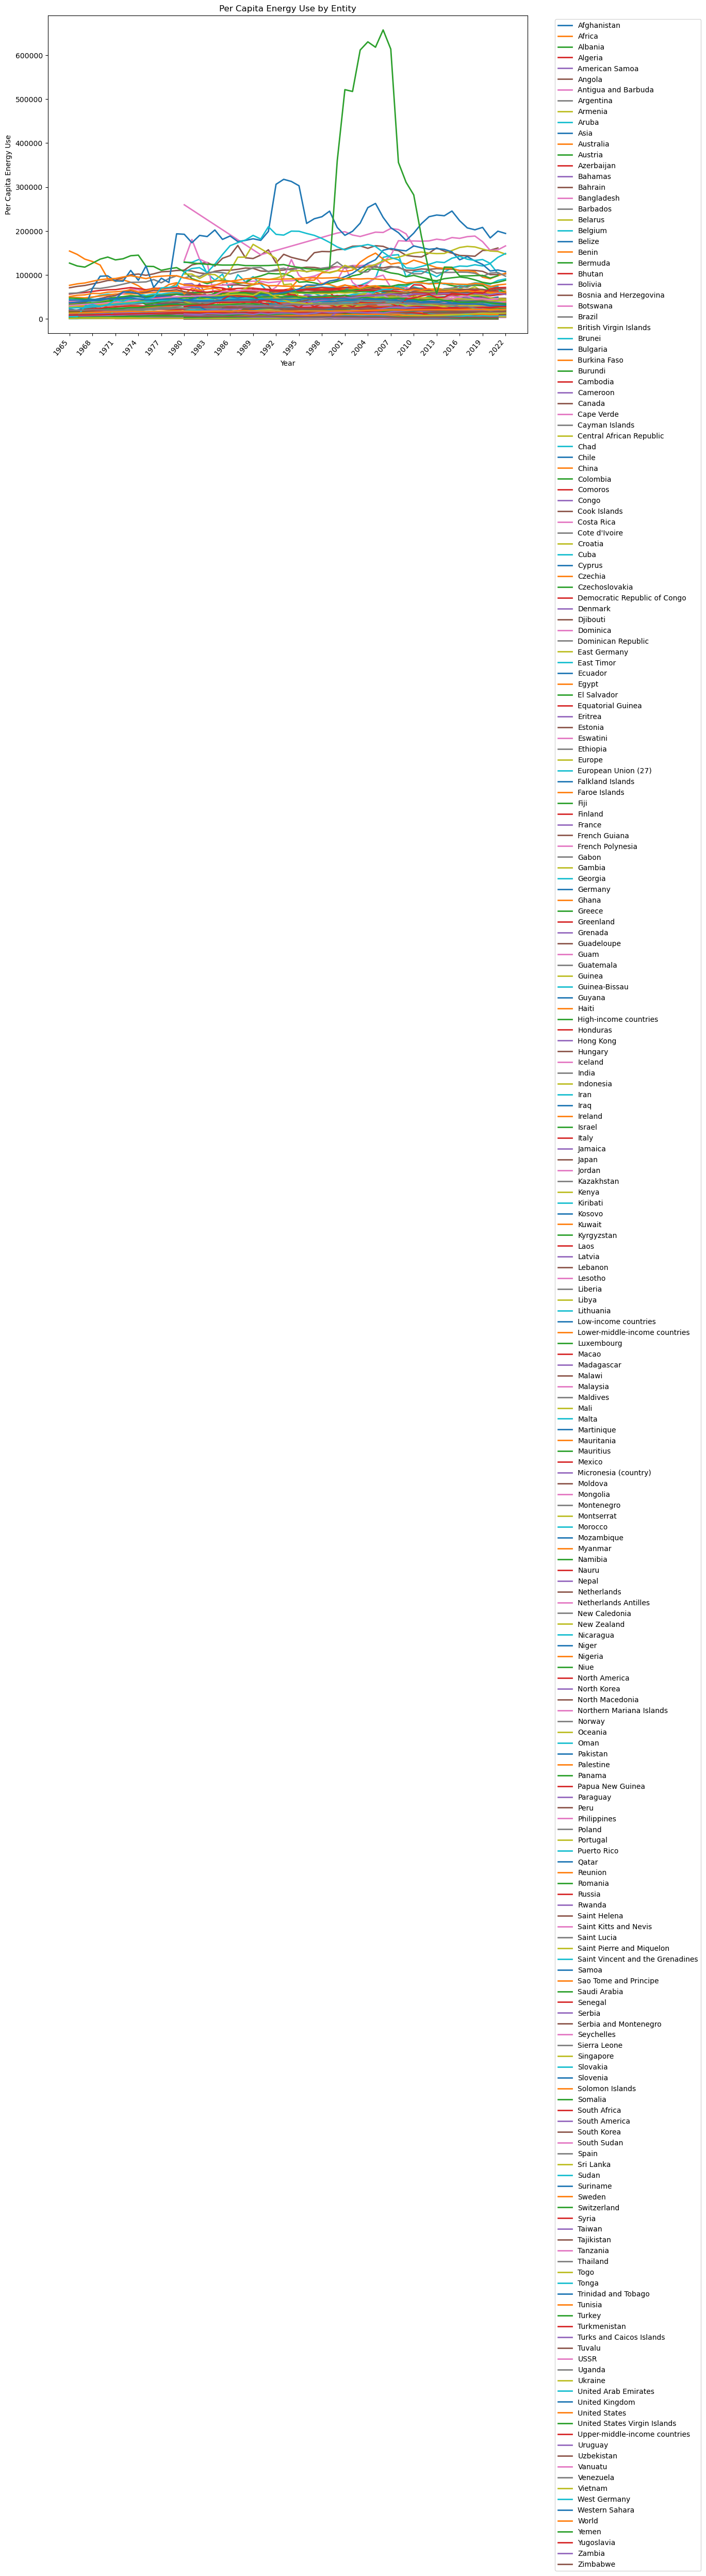

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
energy_data = pd.read_csv('per-capita-energy-use.csv')

# Plot entity separately
plt.figure(figsize=(12, 8))

# Unique entities
for i, entity in enumerate(energy_data['Entity'].unique()):
    entity_data = energy_data[energy_data['Entity'] == entity]
    plt.plot(entity_data['Year'], entity_data['Primary energy consumption per capita (kWh/person)'], label=entity, linewidth=2)

plt.title('Per Capita Energy Use by Entity')
plt.xlabel('Year')
plt.ylabel('Per Capita Energy Use')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# In the range of 3
years = range(solar_energy_data['Year'].min(), solar_energy_data['Year'].max() + 1, 3)
plt.xticks(years, rotation=50, ha='right')


plt.show()

Mean Squared Error: 1224812620.026569
R-squared Score: -0.00098953042220562


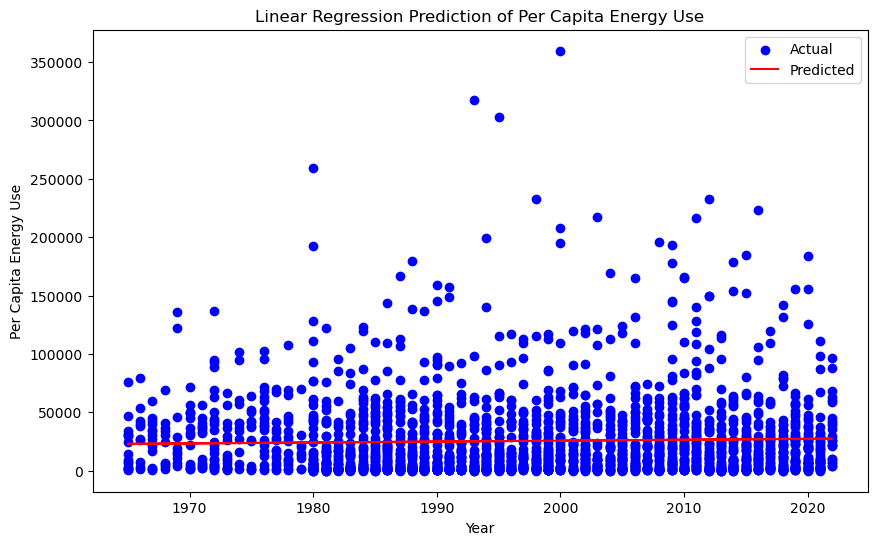

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
energy_data = pd.read_csv('per-capita-energy-use.csv')

# Extracting features and target variable
X = energy_data[['Year']]  # as the feature
y = energy_data['Primary energy consumption per capita (kWh/person)']  # Predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Linear Regression Prediction of Per Capita Energy Use')
plt.xlabel('Year')
plt.ylabel('Per Capita Energy Use')
plt.legend()
plt.show()

Accuracy: 0.528052805280528

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.55      0.53      1039
           1       0.54      0.51      0.52      1082

    accuracy                           0.53      2121
   macro avg       0.53      0.53      0.53      2121
weighted avg       0.53      0.53      0.53      2121



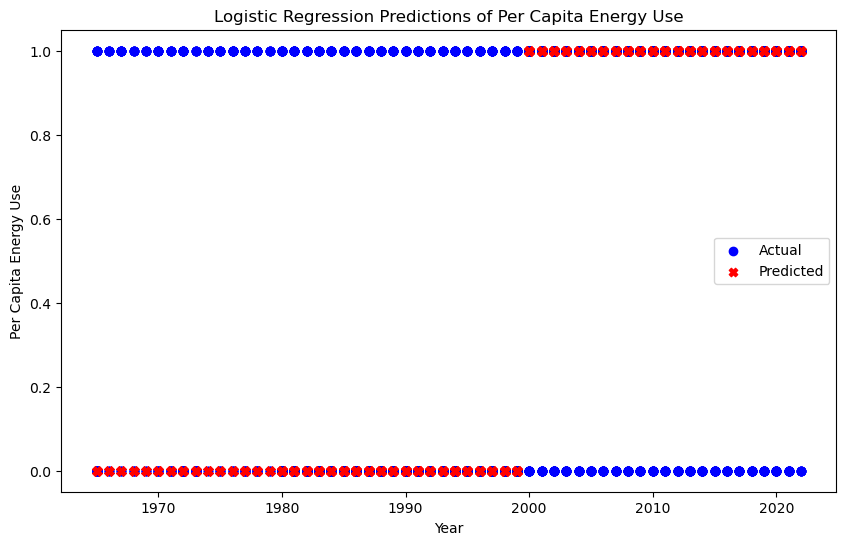

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
energy_data = pd.read_csv('per-capita-energy-use.csv')

# Extracting features and target variable
X = energy_data[['Year']]  # Use 'Year' as a feature
y = np.where(energy_data['Primary energy consumption per capita (kWh/person)'] > energy_data['Primary energy consumption per capita (kWh/person)'].median(), 1, 0)  # Classify based on median

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', marker='X', label='Predicted')
plt.title('Logistic Regression Predictions of Per Capita Energy Use')
plt.xlabel('Year')
plt.ylabel('Per Capita Energy Use')
plt.legend()
plt.show()

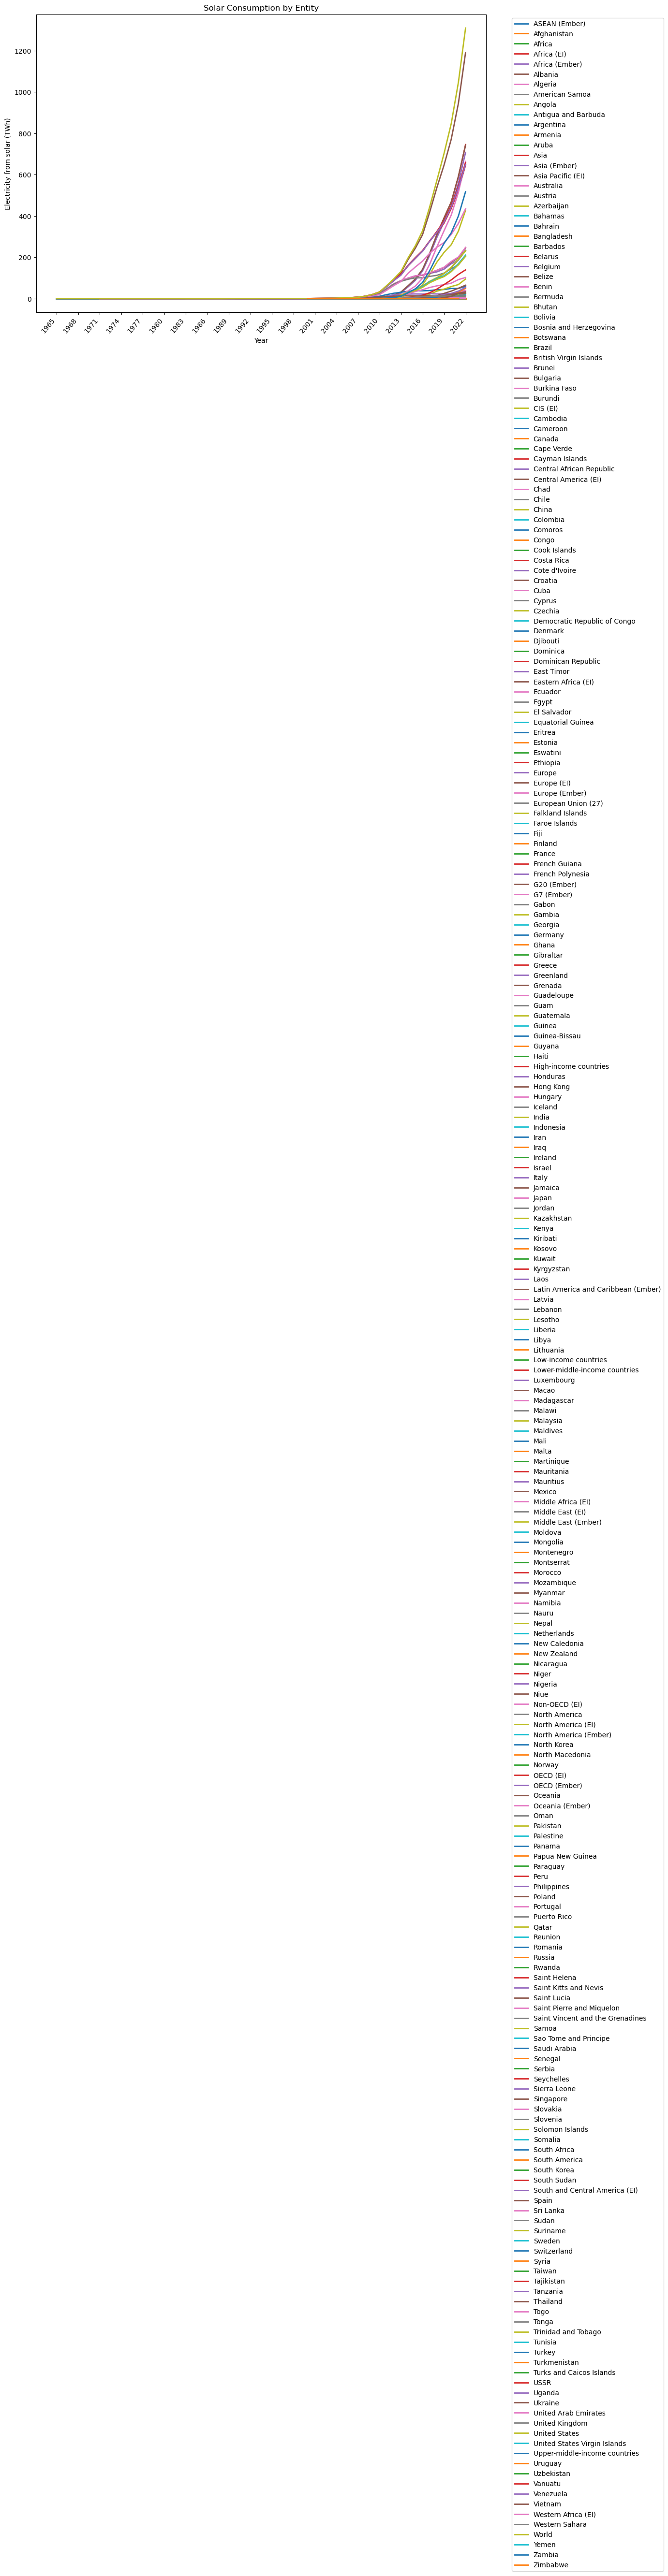

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
solar_energy_data = pd.read_csv('solar-energy-consumption.csv')

# Plot entity separately
plt.figure(figsize=(12, 8))

# Unique entities
for i, entity in enumerate(solar_energy_data['Entity'].unique()):
    entity_data = solar_energy_data[solar_energy_data['Entity'] == entity]
    plt.plot(entity_data['Year'], entity_data['Electricity from solar - TWh'], label=entity, linewidth=2)

plt.title('Solar Consumption by Entity')
plt.xlabel('Year')
plt.ylabel('Electricity from solar (TWh)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# In the range of 3
years = range(solar_energy_data['Year'].min(), solar_energy_data['Year'].max() + 1, 3)
plt.xticks(years, rotation=50, ha='right')


plt.show()

Mean Squared Error: 4055.137687374717
R-squared Score: 0.022147628287188303


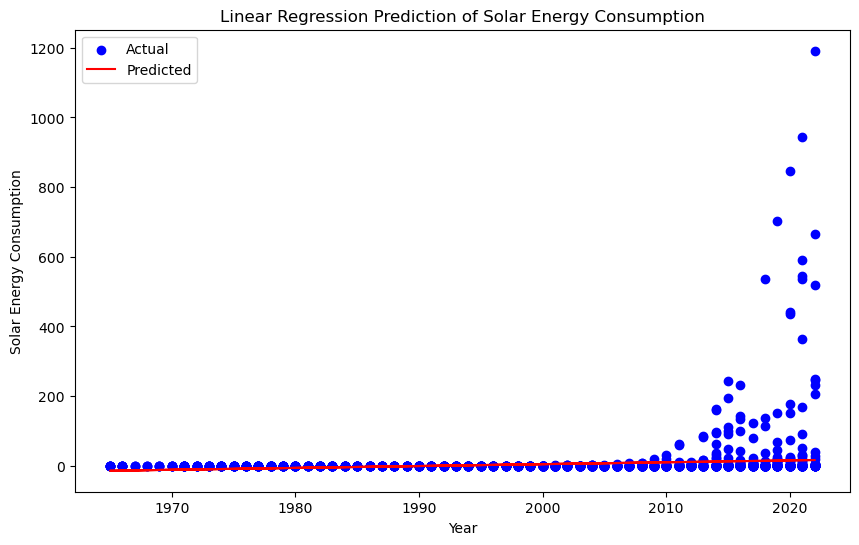

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
solar_energy_data = pd.read_csv('solar-energy-consumption.csv')

# Extracting features and target variable
X = solar_energy_data[['Year']]  # as the feature
y = solar_energy_data['Electricity from solar - TWh']  # Predict

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Visualize
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', label='Predicted')
plt.title('Linear Regression Prediction of Solar Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Solar Energy Consumption')
plt.legend()
plt.show()

Accuracy: 0.782035175879397

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       997
           1       0.75      0.63      0.68       595

    accuracy                           0.78      1592
   macro avg       0.77      0.75      0.76      1592
weighted avg       0.78      0.78      0.78      1592



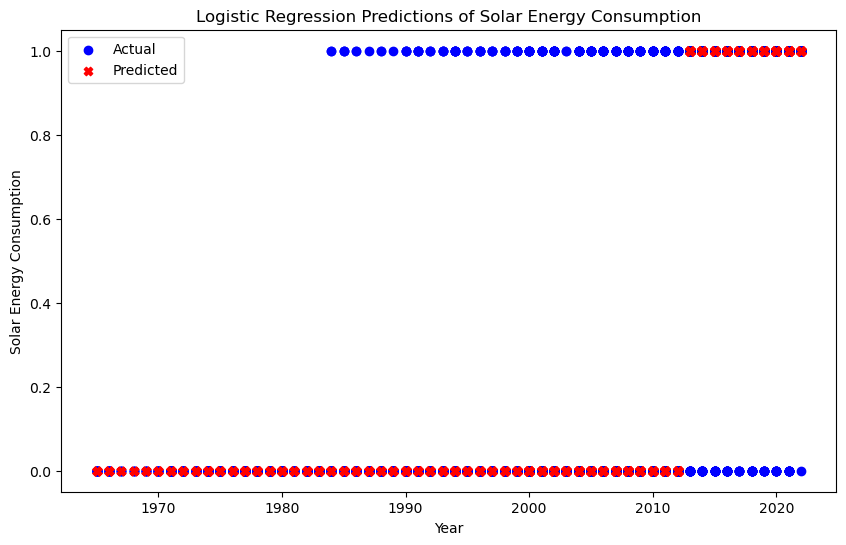

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
solar_energy_data = pd.read_csv('solar-energy-consumption.csv')

# Extracting features and target variable
X = solar_energy_data[['Year']]  # Use 'Year' as a feature
y = np.where(solar_energy_data['Electricity from solar - TWh'] > solar_energy_data['Electricity from solar - TWh'].median(), 1, 0)  # Classify based on median

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', marker='X', label='Predicted')
plt.title('Logistic Regression Predictions of Solar Energy Consumption')
plt.xlabel('Year')
plt.ylabel('Solar Energy Consumption')
plt.legend()
plt.show()